1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

In [75]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, roc_auc_score, log_loss, confusion_matrix
from sklearn.ensemble import GradientBoostingRegressor
import itertools

from prettytable import PrettyTable
import matplotlib.pyplot as plt

%matplotlib inline

In [76]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [77]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

In [78]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [79]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [80]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))


In [81]:
feats = FeatureUnion(final_transformers)
b=1
score = []

In [82]:
# Логистическая регрессия
lr_classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

#запустим кросс-валидацию
cv_scores = cross_val_score(lr_classifier, X_train, y_train, cv=16, scoring='roc_auc')

#обучим пайплайн на всем тренировочном датасете
lr_classifier.fit(X_train, y_train)
y_score = lr_classifier.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)

cv_score = np.mean(cv_scores)
roc_auc = roc_auc_score(y_true=y_test, y_score=y_score)
log_los = log_loss(y_true=y_test, y_pred=y_score)

# найдем индекс с максимальным fscore
ix = np.argmax(fscore)

score.append(['LogisticRegression', thresholds[ix] , fscore[ix], precision[ix], recall[ix], cv_score, roc_auc, log_los])

In [83]:
# Градиентный бустинг
gb_classifier = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingRegressor(random_state=42,
                                    min_samples_split=2)),
     ])

#запустим кросс-валидацию
cv_scores = cross_val_score(gb_classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)

#обучим пайплайн на всем тренировочном датасете
gb_classifier.fit(X_train, y_train)
y_score = gb_classifier.predict(X_test)

precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)

cv_score = np.mean(cv_scores)
roc_auc = roc_auc_score(y_test, y_score)
log_los = log_loss(y_test.values, y_score)

# найдем индекс с максимальным fscore
ix = np.argmax(fscore)

score.append(['GradientBoosting', thresholds[ix] , fscore[ix], precision[ix], recall[ix], cv_score, roc_auc, log_los])

In [84]:
mytable = PrettyTable()
mytable.align = "r"
values = ['threshold', 'fscore', 'precision', 'recall', 'cv score', 'roc auc', 'log loss']
for val in values:
    mytable.float_format[val] = ".5"
# имена полей таблицы
mytable.field_names = ['algoritm'] + values 
# добавление данных по одной строке за раз
for i in range(2):
    mytable.add_row([elem for elem in score[i]])
# вывод таблицы 
print(mytable)

+--------------------+-----------+---------+-----------+---------+----------+---------+----------+
|      algoritm      | threshold |  fscore | precision |  recall | cv score | roc auc | log loss |
+--------------------+-----------+---------+-----------+---------+----------+---------+----------+
| LogisticRegression |  0.28952  | 0.50970 |  0.46240  | 0.56778 | 0.76172  | 0.77208 | 0.42678  |
|  GradientBoosting  |  0.36022  | 0.64646 |  0.66528  | 0.62868 | 0.85909  | 0.87016 | 0.39268  |
+--------------------+-----------+---------+-----------+---------+----------+---------+----------+


In [85]:
# GradientBoosting лучшая из двух моделей. Наиболее подходящая DS-метрика здесь precision (доля правильно классифициованных 
# удержанных клиентов) и cv_score среднее всех roc_auc при кроссвалидации
# подберем оптимальные гиперпараметры для лучшей модели

params={'classifier__n_estimators':[50,75,100,125],
        'classifier__max_depth':np.arange(3, 7, 1),
        'classifier__min_samples_leaf':[1, 2, 3],
        'classifier__learning_rate':[0.1,1]
        }

grid = GridSearchCV(gb_classifier,
                    param_grid=params,
                    cv=3,
                    scoring='roc_auc',
                    refit=False)

search = grid.fit(X_train, y_train)
search.best_params_

{'classifier__learning_rate': 0.1,
 'classifier__max_depth': 4,
 'classifier__min_samples_leaf': 3,
 'classifier__n_estimators': 50}

In [86]:
# Градиентный бустинг с оптимальными параметрами
opt_gb_classifier = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingRegressor(random_state=42,
                                    min_samples_split=2,
                                    max_depth=4,
                                    min_samples_leaf=3,
                                    n_estimators=50,         
                                    criterion='mse')),
     ])

#запустим кросс-валидацию
cv_scores = cross_val_score(opt_gb_classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)

#обучим пайплайн на всем тренировочном датасете
opt_gb_classifier.fit(X_train, y_train)
y_score = opt_gb_classifier.predict(X_test)

precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)

cv_score = np.mean(cv_scores)
roc_auc = roc_auc_score(y_test, y_score)
log_los = log_loss(y_test.values, y_score)

# найдем индекс с максимальным fscore
ix = np.argmax(fscore)

score.append(['OptGradientBoosting', thresholds[ix] , fscore[ix], precision[ix], recall[ix], cv_score, roc_auc, log_los])

In [87]:
mytable = PrettyTable()
mytable.align = "r"
values = ['threshold', 'fscore', 'precision', 'recall', 'cv score', 'roc auc', 'log loss']
for val in values:
    mytable.float_format[val] = ".5"
# имена полей таблицы
mytable.field_names = ['algoritm'] + values 
# добавление данных по одной строке за раз
for i in range(3):
    mytable.add_row([elem for elem in score[i]])
# вывод таблицы 
print(mytable)

+---------------------+-----------+---------+-----------+---------+----------+---------+----------+
|       algoritm      | threshold |  fscore | precision |  recall | cv score | roc auc | log loss |
+---------------------+-----------+---------+-----------+---------+----------+---------+----------+
|  LogisticRegression |  0.28952  | 0.50970 |  0.46240  | 0.56778 | 0.76172  | 0.77208 | 0.42678  |
|   GradientBoosting  |  0.36022  | 0.64646 |  0.66528  | 0.62868 | 0.85909  | 0.87016 | 0.39268  |
| OptGradientBoosting |  0.33253  | 0.64162 |  0.62949  | 0.65422 | 0.86188  | 0.87417 | 0.35207  |
+---------------------+-----------+---------+-----------+---------+----------+---------+----------+


Confusion matrix, without normalization
[[1795  196]
 [ 177  332]]


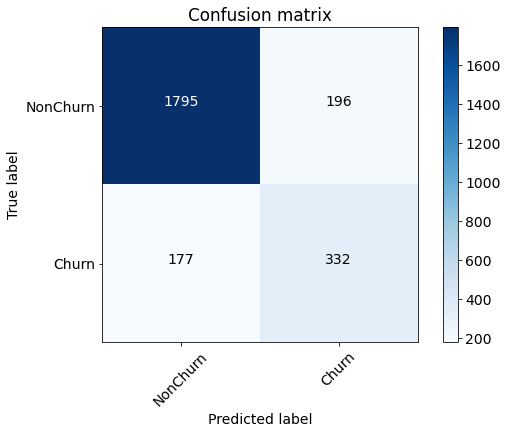

In [88]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

font = {'size' : 14}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [90]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

In [91]:
print(f'TN={TN}, FN={FN}, TP={TP}, FP={FP}')

TN=1795, FN=177, TP=332, FP=196


Те кого мы правильно предсказали принесли нам 2 доллара, т.е. $2 \cdot TP$. Минус затраты на всех предсказанных в отток клиентов $1 \cdot (TP+FP)$.

In [92]:
print(f'экономическая эффективность равна {2*TP-(TP+FP)}')

экономическая эффективность равна 136
